In [1]:
import numpy as np
import datetime as dt
import json
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from random import random
from math import log, sqrt, exp
import seaborn as sns

2024-01-04 15:49:36.654339: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 15:49:46.893896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 15:49:46.894759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 15:50:27.745490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Temperatura da transição de fase. O que queremos que nossa rede aprenda 

In [2]:
ising_tc = 1/(1/2*log(1+sqrt(2)))
ising_tc

2.269185314213022

In [3]:
def up(neighs, i):
    return neighs[0, i]
def right(neighs, i):
    return neighs[1, i]
def down(neighs, i):
    return neighs[2,i]
def left(neighs, i):
    return neighs[3,i]

In [4]:
def monte_carlo(arg_mes_rate, sweeps, L, T):
    # sweeps > 5 deixa o código extremamente lento.
    # Diferentemenete da linguagem Julia, que possui otimizações
    nsweeps = 10**sweeps
    measure_rate = arg_mes_rate
    beta = 1/T
    conf = np.random.choice([-1,1], size=[L,L])
    confs = []
    
    lattice = np.arange(0,(L**2)).reshape(L,L).transpose() 
 
    ups = np.roll(lattice, -1, axis=0).flatten('F') 
    # Primeira linha vira ultima linha, todas as outras movem uma linha para 
    # cima, depois tudo é achatado em um único array, coluna por coluna
    
    rights = np.roll(lattice, -1, axis=1).flatten('F')
    # Primeira coluna vira ultima coluna, todas as outras movem uma linha 
    # para esquerda, depois tudo é achatado em um único array, coluna por coluna 
    
    downs = np.roll(lattice, 1, axis=0).flatten('F')
    # Última linha vira primeira linha, todas as outras movem uma linha para 
    # baixo, depois tudo é achatado em um único array, coluna por coluna
    
    lefts = np.roll(lattice, 1, axis=1).flatten('F')
    # Última coluna vira primeira coluna, todas as outras movem uma coluna para
    # direita, depois tudo é achatado em um único array, coluna por coluna
                                  
    neighs = np.vstack((ups,rights,downs,lefts)) 
    # Todos são concatenados de forma vertical
    
    conf = conf.flatten() 
    # objetivo disso tudo foi para que possamos acessar todos os elementos
    # de uma matriz como se estivessimos acessando um único array.
    
    
    
    start_time = dt.datetime.now()
    print("Início às: ", start_time.strftime("%d-%m-%Y %H:%M:%S"))
    
    for i in range(0, nsweeps):
        for element in range(0, len(conf)):
            
            delta_e = 2.0 * conf[element] * (conf[up(neighs,element)] + conf[right(neighs, element)] +
                            + conf[down(neighs, element)] + conf[left(neighs, element)])
           
            if delta_e <= 0 or random() < exp(-beta*delta_e):
                conf[element] *= -1 # Flip
                
        if i % measure_rate == 0:
            confs.append(conf.copy())
    
    end_time = dt.datetime.now()
    print("Término às: ", end_time.strftime("%d-%m-%Y %H:%M:%S"))
    
    return confs

In [5]:
ts = [1.189, 1.733, 2.069, 2.269, 2.278, 2.469, 2.822, 3.367]
rate = 5000
sweeps = 7

confs = dict()
for t in ts:
    print("T = ", t)
    temp = monte_carlo(rate, sweeps, L=8, T=t)
    confs[t] = temp

T =  1.189
Início às:  04-01-2024 15:50:58
Término às:  04-01-2024 16:31:03
T =  1.733
Início às:  04-01-2024 16:31:03
Término às:  04-01-2024 17:12:31
T =  2.069
Início às:  04-01-2024 17:12:31
Término às:  04-01-2024 17:52:24
T =  2.269
Início às:  04-01-2024 17:52:24
Término às:  04-01-2024 18:32:46
T =  2.278
Início às:  04-01-2024 18:32:46
Término às:  04-01-2024 19:13:02
T =  2.469
Início às:  04-01-2024 19:13:02
Término às:  04-01-2024 19:53:03
T =  2.822
Início às:  04-01-2024 19:53:03
Término às:  04-01-2024 20:33:22
T =  3.367
Início às:  04-01-2024 20:33:22
Término às:  04-01-2024 21:14:22


Vamos gerar dados para um conjunto de 8 temperaturas(note que a temperatura exata de transição encontra-se no conjunto)

<AxesSubplot:>

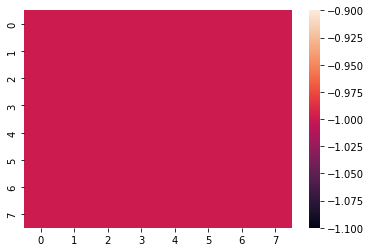

In [14]:
sns.heatmap(confs[ts[0]][10].reshape(8,8))

<AxesSubplot:>

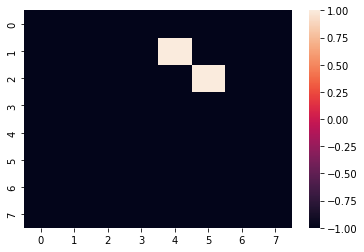

In [15]:
sns.heatmap(confs[ts[2]][10].reshape(8,8))

<AxesSubplot:>

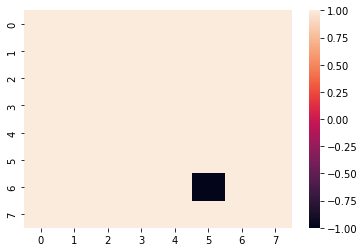

In [17]:
sns.heatmap(confs[ts[4]][10].reshape(8,8))

Em temperaturas mais baixas temos uma tendência de que os spins estejam alinhados, criando-se um sistema ferromagnético

<AxesSubplot:>

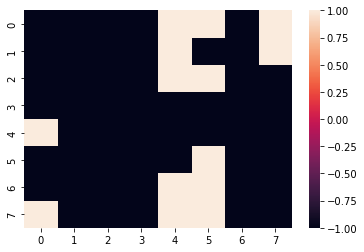

In [19]:
sns.heatmap(confs[ts[5]][10].reshape(8,8))

<AxesSubplot:>

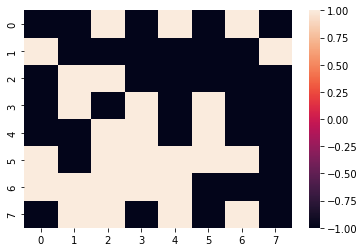

In [20]:
sns.heatmap(confs[ts[7]][10].reshape(8,8))

Em temperaturas mais altas vemos que os spins estão aleatoriamente distribuídos, temos um sistema paramagnético

In [21]:
count=0
for item in confs.keys():
    count += len(confs[item])
print(count)

16000


Temos 16000 amostrar para treinarmos e avaliarmos nosso modelo

In [22]:
ferro_magnetic = list()
para_magnetic = list()
ferro_mag_code = list() # Código ferro == 0
para_mag_code = list() #  Código para  == 1


for item in confs.keys():
    if item < ising_tc:
        print("Ferro: ", item)
        print(len(confs[item]))
        ferro_magnetic += confs[item]
        ferro_mag_code += [0 for i in range(0,len(confs[item]))]
    elif item > ising_tc:
        print("Para: ", item)
        print(len(confs[item]))
        para_magnetic += confs[item]
        para_mag_code += [1 for i in range(0,len(confs[item]))]

Ferro:  1.189
2000
Ferro:  1.733
2000
Ferro:  2.069
2000
Ferro:  2.269
2000
Para:  2.278
2000
Para:  2.469
2000
Para:  2.822
2000
Para:  3.367
2000


Queremos montar o seguinte esquema para salvarmos os dados:

{1: [ ( [1, 2, 3], 0 ) ]

In [25]:
confs_classified = dict()

for item in confs.keys():
    confs_classified[item] = list()
    if item < ising_tc:
        for value in confs[item]:
            tup = (value,0)
            confs_classified[item].append(tup)
    else:
        for value in confs[item]:
            tup = (value, 1)
            confs_classified[item].append(tup)

Vamos reservar 20% das amostras para ser o conjunto de dados

Poderiamos utilizar a famosa "train_test_split" da biblioteca scikit learn, mas iremos utilizar apenas numpy 

In [32]:
from random import sample

In [56]:
train = dict()
test = dict()


for temp in confs_classified.keys():
    data_qtd = len(confs_classified[temp])
    
    sample_size = int(data_qtd*0.2) # 20% de cada temperatura para o conjunto de testes
    
    test_indices = [i for i in range(0, data_qtd)] # Geramos uma lista de números indo do 0 até o tamanho do conjunto
    test_indices = sample(test_indices, sample_size) # Selecionamos uma parte desses números gerados, são os 
                                                     # indices 
    
    test[temp] = list()
    train[temp] = list()
    
    for pos in range(0, data_qtd):
        
        first_item2list = confs_classified[temp][pos][0].tolist()
        second_item = confs_classified[temp][pos][1]
        
        
        current_pos = (first_item2list,second_item)
        
        
        if pos in test_indices:
            test[temp].append(current_pos)
        else:
            train[temp].append(current_pos)
    

In [64]:
def salva_teste():
    file_name = "test.txt"
    with open(file_name, 'w') as file:
        json.dump(test, file)

In [65]:
def salva_treino():
    file_name = "train.txt"
    with open(file_name, 'w') as file:
        json.dump(train, file)

In [66]:
salva_teste()
salva_treino()